In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import utils as mutil
import sklearn
import sklearn.ensemble
import sklearn.model_selection

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
titanic_train = pd.read_csv("titanic/train.csv")
titanic_train_ids = titanic_train['PassengerId']
titanic_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [3]:
titanic_test_with_labels = pd.read_csv("../../project/test-set-solution.csv")
titanic_test_with_labels = titanic_test_with_labels.drop(columns=["boat", "body", "home.dest"])
titanic_test_with_labels["PassengerId"] = [titanic_train.shape[0] + i for i in range(titanic_test_with_labels.shape[0])]
#titanic_test_with_labels.head()
merge = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='left', indicator=True)
merge["duplicate"] = merge["_merge"] == "both"
# merge.groupby("duplicate")["duplicate"].count()
titanic_test_with_labels_u = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='outer', indicator=True).query('_merge=="left_only"').drop("_merge", axis=1)
titanic_test_with_labels_u = titanic_test_with_labels_u.drop(columns=["PassengerId_y", "Survived_y", "Pclass_y", "Age_y", "SibSp_y", "Parch_y", "Ticket_y", "Embarked_y", "Sex_y", "Fare_y", "Cabin_y"])
titanic_test_with_labels_u.rename(columns={
    "Pclass_x": "Pclass",
    "Survived_x": "Survived",
    "Sex_x": "Sex",
    "Age_x": "Age",
    "SibSp_x": "SibSp", 
    "Parch_x": "Parch",
    "Ticket_x": "Ticket",
    "Fare_x": "Fare",
    "Cabin_x": "Cabin",
    "Embarked_x": "Embarked",
    "PassengerId_x": "PassengerId",}, inplace=True)
titanic_test_with_labels_u

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,894
10,1,0,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C,901
19,1,0,"Beattie, Mr. Thomson",male,36.0,0,0,13050,75.2417,C6,C,910
24,1,1,"Bird, Miss. Ellen",female,29.0,0,0,PC 17483,221.7792,C97,S,915
25,1,0,"Birnbaum, Mr. Jakob",male,25.0,0,0,13905,26.0000,NaN,C,916
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,3,0,"Willer, Mr. Aaron (""Abi Weller"")",male,NaN,0,0,3410,8.7125,NaN,S,2182
1296,3,0,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2187
1298,3,0,"Wittevrongel, Mr. Camille",male,36.0,0,0,345771,9.5000,NaN,S,2189
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,2197


In [4]:
def preprocess(dataframe: pd.DataFrame):
    df = dataframe.copy()
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df['Embarked'] = df['Embarked'].fillna('S').map(lambda c: embarked_map[c])
    df['Sex'] = df['Sex'].map(lambda c: 0 if c == 'male' else 1)
    # Drop all unused columns
    df = df.drop(columns=drop_columns)
    # Remove rows with missing data
    df = df.dropna()
    return df

## Descision tree

In [5]:
titanic_train_clean = preprocess(titanic_train)
# Create training dataset
train_x = titanic_train_clean.drop(columns=['Survived'])
train_y = titanic_train_clean['Survived']
# Train model
model = sklearn.tree.DecisionTreeClassifier(max_depth=4, class_weight="balanced")
model = model.fit(X=train_x, y=train_y)
# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%")

Train accuracy 0.8277310924369747
Training set utilisation = 80.13468013468014%


In [6]:

# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
# Create training dataset
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)} utilisation = {100 * len(titanic_test_with_labels_clean) / len(titanic_test_with_labels_u)}%")

Test score = 0.723404255319149
Missing classifications = 87 utilisation = 79.08653846153847%


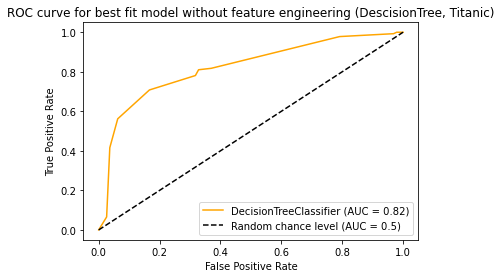

In [7]:
mutil.plot_roc(model, test_x, test_y, title="ROC curve for best fit model without feature engineering (DescisionTree, Titanic)")

In [8]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.7253156214459547


## Random Forrest

In [9]:
# Train model
model = sklearn.ensemble.RandomForestClassifier(min_samples_split= 10, n_estimators= 100, criterion='gini', min_samples_leaf= 1, class_weight="balanced")
model = model.fit(X=train_x, y=train_y)

# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%\n")

# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)} utilisation = {100 * len(titanic_test_with_labels_clean) / len(titanic_test_with_labels_u)}%")

Train accuracy 0.9061624649859944
Training set utilisation = 80.13468013468014%

Test score = 0.7781155015197568
Missing classifications = 87 utilisation = 79.08653846153847%


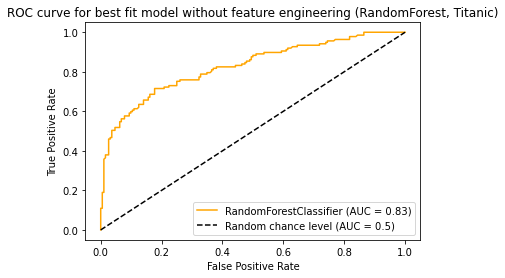

In [10]:
mutil.plot_roc(model, test_x, test_y, title="ROC curve for best fit model without feature engineering (RandomForest, Titanic)")

In [11]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.7774793708487573
